Predicting Price Moves with News Sentiment

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mukit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\mukit\AppData\Local\Temp\ipykernel_10428\705391603.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dates = dates.fillna(new_dates)
C:\Users\mukit\AppData\Local\Temp\ipykernel_10428\705391603.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dates = dates.fillna(new_dates)
C:\Users\mukit\AppData\Local\Temp\ipykernel_10428\705391603.py:25: FutureWarning: Downcasting object d


🔍 Processing TSLA ...
Same-day correlation: r = nan, p = nan
Next-day correlation: r = nan, p = nan


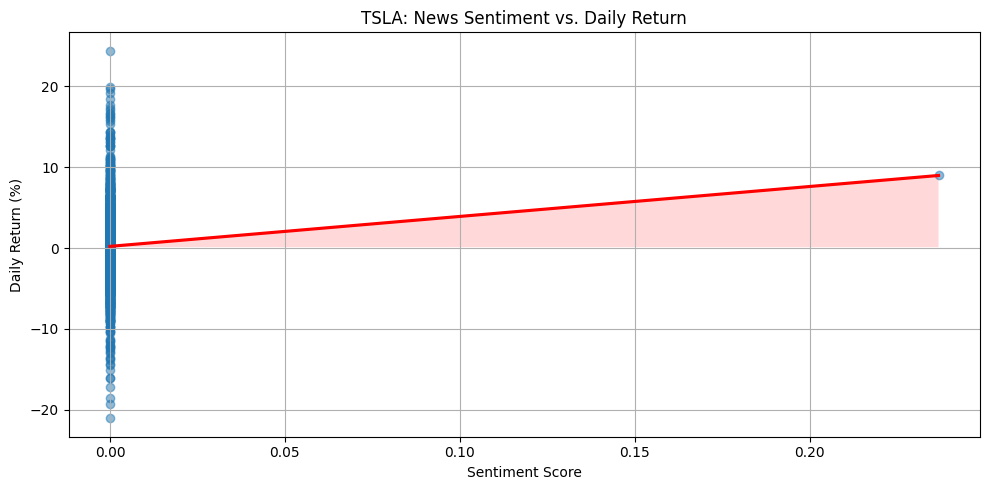


🔍 Processing NVDA ...
Same-day correlation: r = nan, p = nan
Next-day correlation: r = nan, p = nan


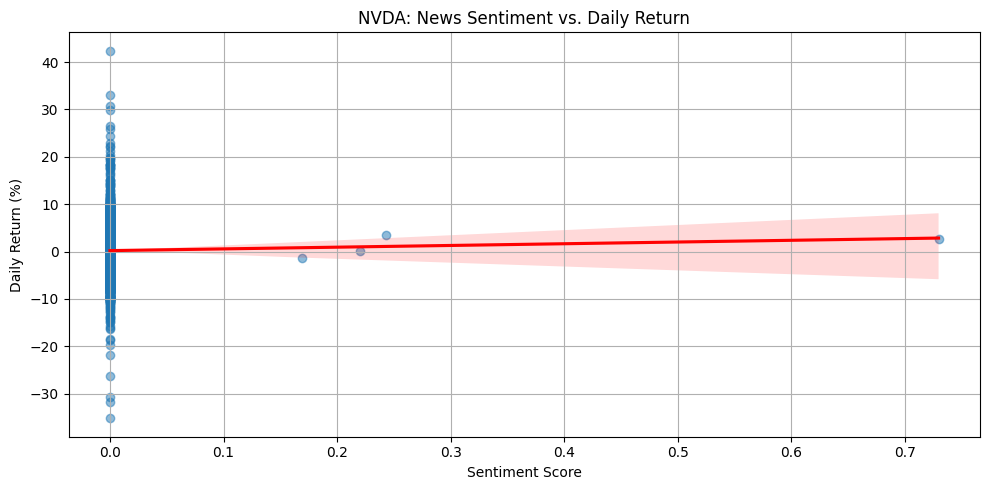


🔍 Processing MSFT ...
Same-day correlation: r = nan, p = nan
Next-day correlation: r = nan, p = nan


C:\Users\mukit\AppData\Local\Temp\ipykernel_10428\705391603.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0)
C:\Users\mukit\AppData\Local\Temp\ipykernel_10428\705391603.py:71: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_same, p_same = pearsonr(merged_df['sentiment_score'], merged_df['daily_return_pct'])
C:\Users\mukit\AppData\Local\Temp\ipykernel_10428\705391603.py:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_next, p_next = pearsonr(merged_df['sentiment_score'], merged_df['next_day_return'])


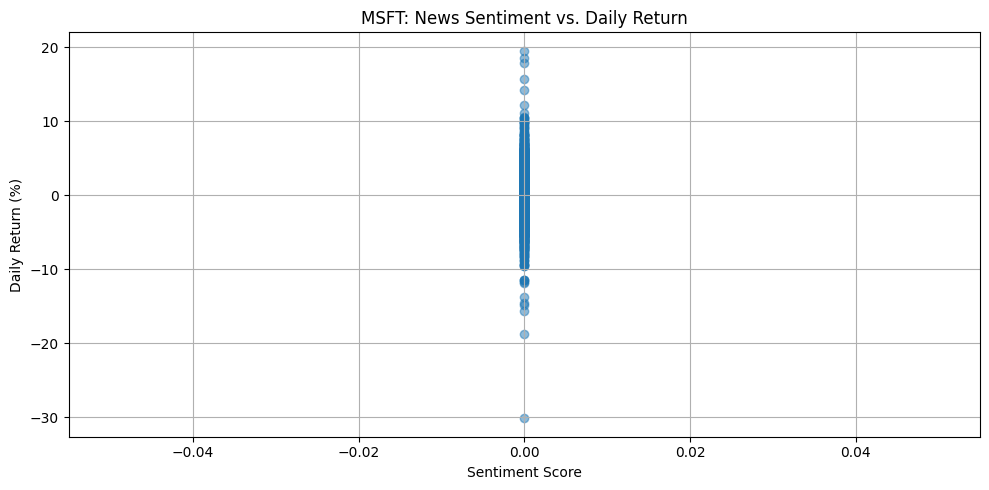


🔍 Processing META ...
Same-day correlation: r = nan, p = nan
Next-day correlation: r = nan, p = nan


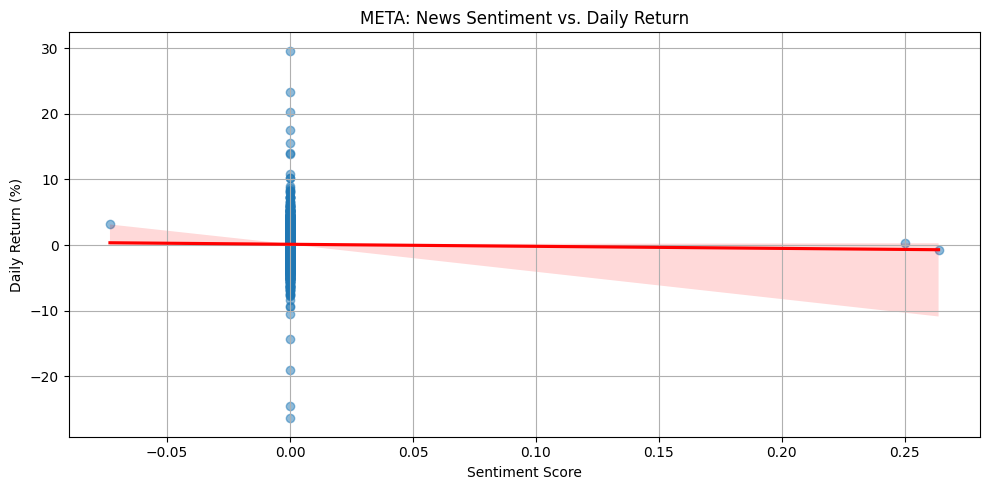


🔍 Processing GOOG ...
Same-day correlation: r = nan, p = nan
Next-day correlation: r = nan, p = nan


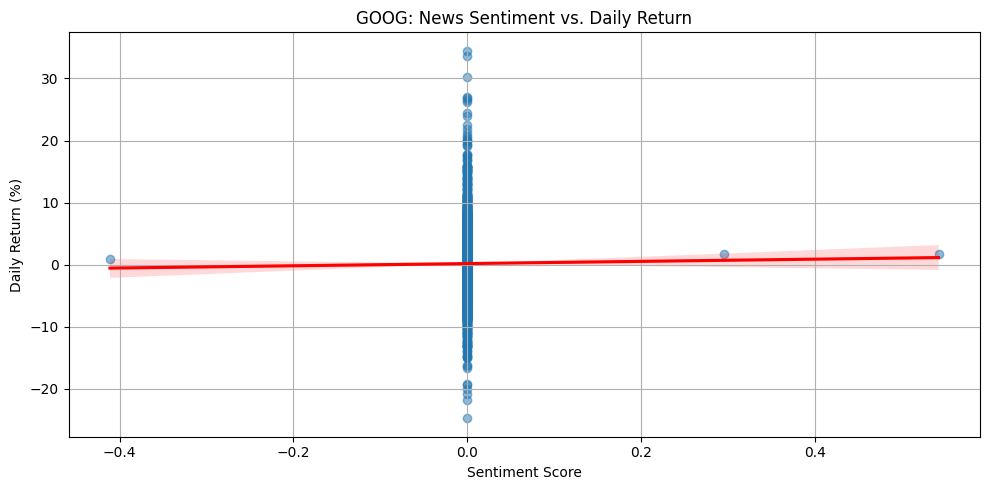

In [7]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, date
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Download VADER lexicon
nltk.download('vader_lexicon')

# =============================
# 1. Helper Functions
# =============================

def safe_date_parse(date_series):
    """Try parsing dates with fallback formats."""
    dates = pd.to_datetime(date_series, errors='coerce')
    if dates.isna().any():
        for fmt in ['%m/%d/%Y', '%d-%m-%Y', '%Y%m%d', '%b %d %Y', '%d %b %Y']:
            try:
                new_dates = pd.to_datetime(date_series, format=fmt, errors='coerce')
                dates = dates.fillna(new_dates)
            except:
                continue
    return dates

def get_sentiment(text, sid):
    """Compute compound sentiment score using VADER."""
    if pd.isna(text):
        return 0
    return sid.polarity_scores(str(text))['compound']

def process_stock(symbol, file_path, news_df, sid):
    print(f"\n🔍 Processing {symbol} ...")

    # =============================
    # Filter News for Stock
    # =============================
    stock_news = news_df[news_df['stock'].str.upper().isin([symbol, alias_map.get(symbol, '')])].copy()
    stock_news['sentiment_score'] = stock_news['headline'].apply(lambda x: get_sentiment(x, sid))
    stock_news['date_only'] = stock_news['date'].dt.date

    # =============================
    # Load Stock Price
    # =============================
    df_stock = pd.read_csv(file_path)
    df_stock = df_stock.rename(columns={'Date': 'date', 'Close': 'close'})
    df_stock['date'] = safe_date_parse(df_stock['date'])
    df_stock = df_stock.dropna(subset=['date']).sort_values('date')
    df_stock['daily_return_pct'] = df_stock['close'].pct_change() * 100
    df_stock['date_only'] = df_stock['date'].dt.date

    # =============================
    # Merge & Analyze
    # =============================
    merged_df = pd.merge(
        df_stock,
        stock_news.groupby('date_only')['sentiment_score'].mean().reset_index(),
        on='date_only',
        how='left'
    )
    merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0)
    merged_df['next_day_return'] = merged_df['daily_return_pct'].shift(-1)

    # =============================
    # Correlation Analysis
    # =============================
    r_same, p_same = pearsonr(merged_df['sentiment_score'], merged_df['daily_return_pct'])
    r_next, p_next = pearsonr(merged_df['sentiment_score'], merged_df['next_day_return'])

    print(f"Same-day correlation: r = {r_same:.3f}, p = {p_same:.4f}")
    print(f"Next-day correlation: r = {r_next:.3f}, p = {p_next:.4f}")

    # =============================
    # Visualization
    # =============================
    plt.figure(figsize=(10, 5))
    sns.regplot(data=merged_df, x='sentiment_score', y='daily_return_pct',
                scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.title(f"{symbol}: News Sentiment vs. Daily Return")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Daily Return (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# =============================
# 2. Load and Clean News Data
# =============================
news_path = r"C:\Users\mukit\Desktop\Kify AIML\Code Part\Week 1\-Predicting-Price-Moves-with-News-Sentiment\Data\raw_analyst_ratings\raw_analyst_ratings.csv"
news_df = pd.read_csv(news_path)
news_df.columns = [col.lower() for col in news_df.columns]
news_df['date'] = safe_date_parse(news_df['date'])
news_df = news_df.dropna(subset=['date'])
news_df['date'] = pd.to_datetime(news_df['date'])
if news_df['date'].dt.tz is None:
    news_df['date'] = news_df['date'].dt.tz_localize('America/New_York')

# =============================
# 3. Define Stock Paths
# =============================
stock_paths = {
    'TSLA': r"C:\Users\mukit\Desktop\Kify AIML\Code Part\Week 1\-Predicting-Price-Moves-with-News-Sentiment\Data\yfinance_data\yfinance_data\TSLA_historical_data.csv",
    'NVDA': r"C:\Users\mukit\Desktop\Kify AIML\Code Part\Week 1\-Predicting-Price-Moves-with-News-Sentiment\Data\yfinance_data\yfinance_data\NVDA_historical_data.csv",
    'MSFT': r"C:\Users\mukit\Desktop\Kify AIML\Code Part\Week 1\-Predicting-Price-Moves-with-News-Sentiment\Data\yfinance_data\yfinance_data\MSFT_historical_data.csv",
    'META': r"C:\Users\mukit\Desktop\Kify AIML\Code Part\Week 1\-Predicting-Price-Moves-with-News-Sentiment\Data\yfinance_data\yfinance_data\META_historical_data.csv",
    'GOOG': r"C:\Users\mukit\Desktop\Kify AIML\Code Part\Week 1\-Predicting-Price-Moves-with-News-Sentiment\Data\yfinance_data\yfinance_data\AMZN_historical_data.csv"
}

# Handle alternate ticker symbols (e.g., FB for META)
alias_map = {
    'META': 'FB'
}

# =============================
# 4. Initialize Sentiment Model
# =============================
sid = SentimentIntensityAnalyzer()

# =============================
# 5. Process Each Stock
# =============================
for symbol, path in stock_paths.items():
    process_stock(symbol, path, news_df, sid)
